In [ ]:
%pip install --upgrade category-encoders
%pip install "scikit-learn==1.6.1"

In [1]:
import numpy as np
import pandas as pd
import pickle
import numpy as np
import subprocess
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
models = [
    {
        'name': 'cnn_lstm_model',
        'path': 'checkpoints/saved_models/cnn_lstm/cnn_lstm.keras'
    },
    {
        'name': 'gru_model',
        'path': 'checkpoints/saved_models/gru/gru.keras'
    },
    {
        'name': 'lstm_model',
        'path': 'checkpoints/saved_models/lstm/lstm.keras'
    },
]

In [ ]:
data_path = 'processed_data/preprocessed_data'
output_path = 'src/inference/predicted_csv'
os.mkdir(output_path)

seq_length = 24
batch_size = 128

In [ ]:
for model in models:
    print(f"\n{'='*50}")
    print(f"Running predictions for model: {model['name']}")
    print(f"{'='*50}\n")

    # Run the prediction script in folder src/inference
    script_path = os.path.join('src', 'inference', 'rolling_prediction_script.py')
    subprocess.run([
        'python', script_path,
        '--model_path', model['path'],
        '--model_name', model['name'],
        '--data_path', data_path,
        '--output_path', output_path,
        '--seq_length', str(seq_length),
        '--batch_size', str(batch_size)
    ], check=True)

    print(f"\n✓ Completed predictions for {model['name']}")

print("\n" + "="*50)
print("All model predictions completed!")
print(f"Results saved in: {output_path}")

In [ ]:
import pandas as pd
import os
from datetime import datetime
import numpy as np

# Configuration
CLEANED_DATA_PATH = 'processed_data/preprocessed_data/cleaned_data.csv'
PREDICTIONS_BASE_PATH = 'src/inference/predicted_csv'
OUTPUT_BASE_PATH = 'processed_data/complete_csv_oct_nov_2006'

# Create output directory
os.makedirs(OUTPUT_BASE_PATH, exist_ok=True)

# Load original cleaned data
print("Loading original cleaned data...")
df_clean = pd.read_csv(CLEANED_DATA_PATH)
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# Filter for October and November 2006
oct_nov_start = pd.Timestamp('2006-10-01')
oct_nov_end = pd.Timestamp('2006-11-30 23:59:59')
df_oct_nov = df_clean[
    (df_clean['Date'] >= oct_nov_start) & 
    (df_clean['Date'] <= oct_nov_end)
].copy()

print(f"Original October-November data: {len(df_oct_nov)} records")

# Get list of model folders
model_folders = [f for f in os.listdir(PREDICTIONS_BASE_PATH) 
                 if os.path.isdir(os.path.join(PREDICTIONS_BASE_PATH, f))]

print(f"\nFound models: {model_folders}")

for model_name in model_folders:
    print(f"\nProcessing model: {model_name}")
    
    # Load predictions for this model
    pred_file = os.path.join(PREDICTIONS_BASE_PATH, model_name, 'traffic_predictions_oct_nov_2006.csv')
    
    if not os.path.exists(pred_file):
        print(f"  Prediction file not found: {pred_file}")
        continue
    
    df_pred = pd.read_csv(pred_file)
    df_pred['Date'] = pd.to_datetime(df_pred['Date']).dt.normalize()
    
    print(f"  Loaded {len(df_pred)} predictions")
    
    # Create a copy of October-November data for this model
    df_combined = df_oct_nov.copy()
    
    # Add a column to mark original vs predicted data
    df_combined['data_source'] = 'original'
    df_pred['data_source'] = 'predicted'
    
    # Rename predicted traffic column to match original
    df_pred = df_pred.rename(columns={'predicted_traffic': 'traffic_volume'})
    
    # OPTIMIZATION 1: Create a single mapping dictionary for all location-specific columns
    # This avoids multiple .map() operations which can be slow
    print("  Adding missing columns to predictions...")
    location_specific_cols = ['SCATS Number', 'NB_LATITUDE', 'NB_LONGITUDE']
    extra_cols = [col for col in df_oct_nov.columns if col not in df_pred.columns]
    
    if extra_cols:
        # Calculate all location mappings at once
        location_mappings = {}
        for location in df_combined['Location'].unique():
            loc_data = df_combined[df_combined['Location'] == location].iloc[0]
            location_mappings[location] = {col: loc_data[col] for col in extra_cols if col in location_specific_cols}
        
        # Add empty columns first
        for col in extra_cols:
            df_pred[col] = None
            
        # Fill in location-specific columns using the mapping
        for location in df_pred['Location'].unique():
            if location in location_mappings:
                mask = df_pred['Location'] == location
                for col, value in location_mappings[location].items():
                    df_pred.loc[mask, col] = value
    
    # Ensure columns are in the same order
    df_pred = df_pred[df_combined.columns]
    
    # Combine original and predictions
    df_combined = pd.concat([df_combined, df_pred], ignore_index=True)
    
    # Remove duplicates if any
    df_combined = df_combined.drop_duplicates(subset=['Location', 'Date', 'interval_id'], keep='first')

    # If any traffic volume is negative, set to 0
    df_combined['traffic_volume'] = df_combined['traffic_volume'].clip(lower=0)

    # OPTIMIZATION 2: More efficient template generation
    print("  Identifying and filling missing intervals...")
    
    # Get unique locations and dates
    locations = df_combined['Location'].unique()
    dates = pd.date_range(start=oct_nov_start, end=oct_nov_end)
    
    # OPTIMIZATION 3: Pre-compute time_of_day mapping for intervals
    time_of_day_map = {i: f"{i // 4:02d}:{(i % 4) * 15:02d}" for i in range(96)}
    
    # OPTIMIZATION 4: Create a unique key for each location-date-interval combination
    # and use set operations to find missing combinations
    print("  Finding missing combinations using set operations...")
    
    # Create a set of all existing combinations
    existing_combos = set()
    for _, row in df_combined[['Location', 'Date', 'interval_id']].iterrows():
        key = (row['Location'], pd.Timestamp(row['Date']).normalize(), row['interval_id'])
        existing_combos.add(key)
    
    # Create all possible combinations
    all_combos = set()
    missing_records = []
    
    # For each location, build a template record with all location-specific data
    location_templates = {}
    for location in locations:
        # Get first record for this location to use as template
        loc_records = df_combined[df_combined['Location'] == location]
        if len(loc_records) > 0:
            template = loc_records.iloc[0].copy()
            location_templates[location] = template
            
            # Generate all combinations for this location
            for date in dates:
                for interval in range(96):
                    key = (location, date, interval)
                    all_combos.add(key)
                    
                    # If this combination doesn't exist, create a record for it
                    if key not in existing_combos:
                        new_record = template.copy()
                        new_record['Date'] = date
                        new_record['interval_id'] = interval
                        new_record['time_of_day'] = time_of_day_map[interval]
                        new_record['data_source'] = 'added_missing'
                        new_record['traffic_volume'] = np.nan
                        missing_records.append(new_record)
    
    # OPTIMIZATION 5: More efficient adding of missing records
    missing_count = len(missing_records)
    print(f"  Found {missing_count} missing intervals")
    
    if missing_count > 0:
        # Create a DataFrame for missing records and calculate median values
        df_missing = pd.DataFrame(missing_records)
        
        # OPTIMIZATION 6: Calculate median values more efficiently
        if len(df_missing) > 0:
            # Group by Date and interval_id to calculate medians
            print("  Calculating interval medians...")
            median_by_date_interval = df_combined.groupby(['Date', 'interval_id'])['traffic_volume'].median()
            
            # Apply medians using vectorized operations instead of row-by-row
            print("  Applying median values to missing intervals...")
            date_interval_idx = pd.MultiIndex.from_frame(df_missing[['Date', 'interval_id']])
            df_missing['traffic_volume'] = median_by_date_interval.reindex(date_interval_idx).values
        
        # Add missing records to combined data
        df_combined = pd.concat([df_combined, df_missing], ignore_index=True)
    else:
        print("  No missing intervals found.")
        
    # Sort the final dataset
    df_combined = df_combined.sort_values(['Location', 'Date', 'interval_id'])

    # Only keep the most necessary columns
    columns_to_keep = ['Location', 'Date', 'interval_id', 'traffic_volume', 'data_source']
    df_combined = df_combined[columns_to_keep]

    # Save combined data
    output_folder = os.path.join(OUTPUT_BASE_PATH, model_name)
    os.makedirs(output_folder, exist_ok=True)
    output_file = os.path.join(output_folder, f'{model_name}_complete_data.csv')
    df_combined.to_csv(output_file, index=False)

    # Save pickle file for the combined data
    pickle_file = os.path.join(output_folder, f'{model_name}_complete_data.pkl')
    with open(pickle_file, 'wb') as f:
        pickle.dump(df_combined, f)
    
    print(f"  Saved combined data to: {output_file}")
    print(f"  Total records: {len(df_combined)}")
    print(f"  Original records: {len(df_combined[df_combined['data_source'] == 'original'])}")
    print(f"  Predicted records: {len(df_combined[df_combined['data_source'] == 'predicted'])}")
    print(f"  Added missing records: {len(df_combined[df_combined['data_source'] == 'added_missing'])}")
    print(f"  Records with NaN traffic volume: {df_combined['traffic_volume'].isna().sum()}")

print("\nAll models processed successfully!")
print(f"Combined data saved to: {OUTPUT_BASE_PATH}")

Loading original cleaned data...
Original October-November data: 396288 records

Found models: ['cnn_lstm_model', 'gru_model', 'lstm_model']

Processing model: cnn_lstm_model
  Loaded 405696 predictions
  Adding missing columns to predictions...
  Identifying and filling missing intervals...
  Finding missing combinations using set operations...
  Found 288 missing intervals
  Calculating interval medians...
  Applying median values to missing intervals...
  Saved combined data to: inference/complete_csv_oct_nov_2006\cnn_lstm_model\cnn_lstm_model_complete_data.csv
  Total records: 802272
  Original records: 396288
  Predicted records: 405696
  Added missing records: 288
  Records with NaN traffic volume: 0

Processing model: gru_model
  Loaded 405696 predictions
  Adding missing columns to predictions...
  Identifying and filling missing intervals...
  Finding missing combinations using set operations...
  Found 288 missing intervals
  Calculating interval medians...
  Applying median 

In [2]:
file_path = "processed_data\complete_csv_oct_nov_2006\gru_model\gru_model_complete_data.csv"
test_df = pd.read_csv(file_path)
print(test_df.describe())
print(test_df.info())

         interval_id  traffic_volume
count  802272.000000   802272.000000
mean       47.500000      106.037588
std        27.711327       67.360972
min         0.000000        0.000000
25%        23.750000       58.000000
50%        47.500000      104.000000
75%        71.250000      149.217290
max        95.000000      695.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802272 entries, 0 to 802271
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Location        802272 non-null  object 
 1   Date            802272 non-null  object 
 2   interval_id     802272 non-null  int64  
 3   traffic_volume  802272 non-null  float64
 4   data_source     802272 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 30.6+ MB
None


In [3]:
# Check how much memory is used by the DataFrame
print(f"Memory usage: {test_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")

Memory usage: 177.90 MB


Total location-days: 8357
Complete location-days: 8357 (100.00%)
Missing location-days: 0 (0.00%)

Most problematic locations:
Location: AUBURN_RD N of BURWOOD_RD - Completeness: 100.00%
Location: AUBURN_RD S of BURWOOD_RD - Completeness: 100.00%
Location: BALWYN_RD N OF BELMORE_RD - Completeness: 100.00%
Location: BALWYN_RD N OF WHITEHORSE_RD - Completeness: 100.00%
Location: BALWYN_RD N of CANTERBURY_RD - Completeness: 100.00%

Most problematic dates:
Date: 2006-10-01 - Completeness: 100.00%
Date: 2006-10-02 - Completeness: 100.00%
Date: 2006-10-03 - Completeness: 100.00%
Date: 2006-10-04 - Completeness: 100.00%
Date: 2006-10-05 - Completeness: 100.00%


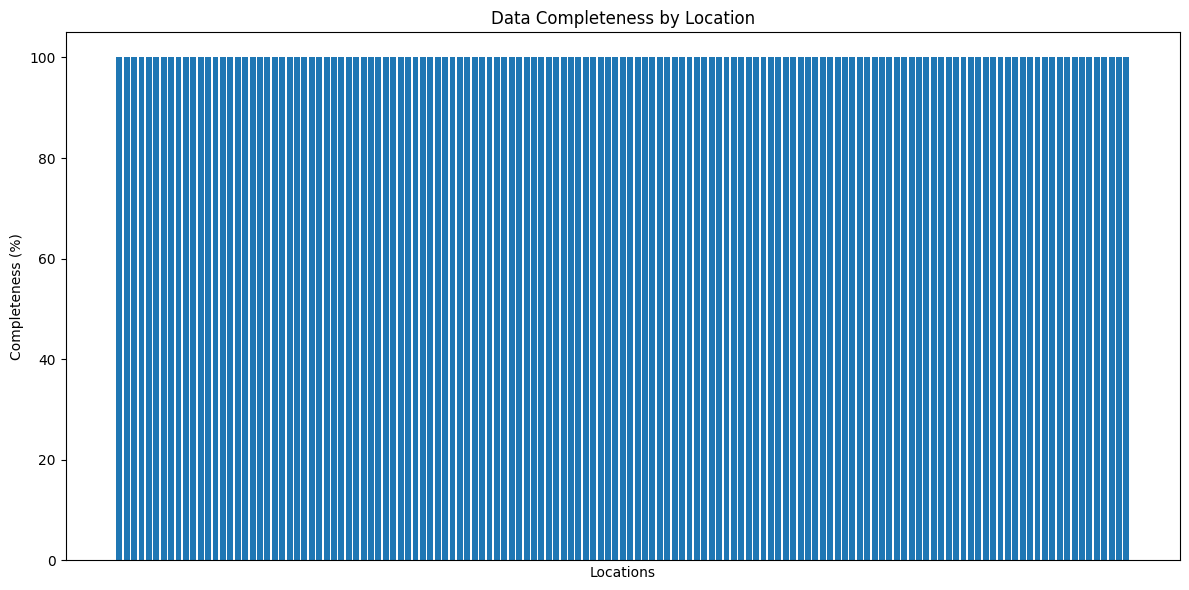

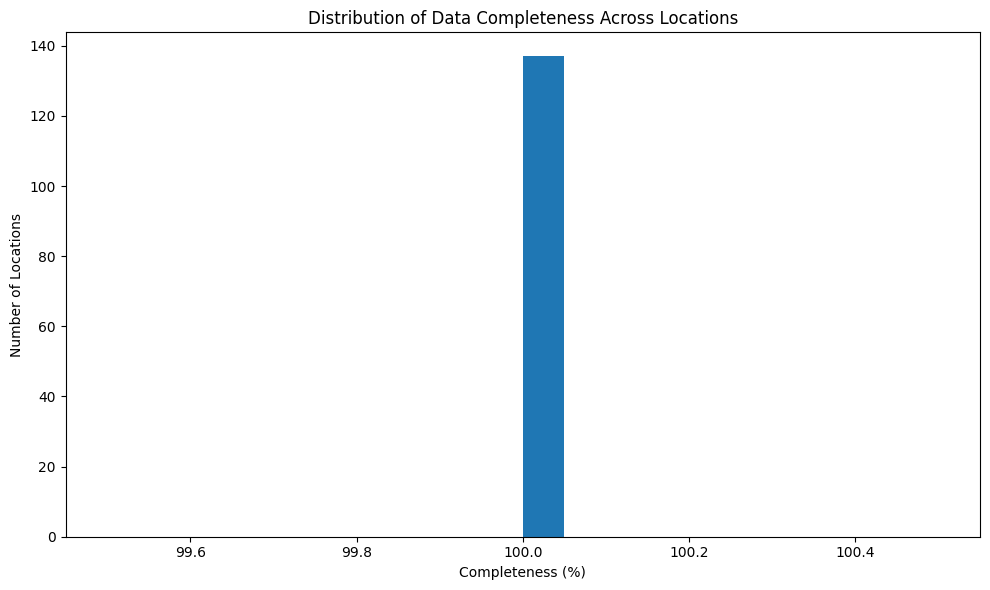

In [ ]:
# Load the data
# Use the most recently used file as an example
df = pd.read_csv(file_path)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Define the date range we want to check
start_date = pd.Timestamp('2006-10-01')
end_date = pd.Timestamp('2006-11-30')
date_range = pd.date_range(start=start_date, end=end_date)

# Get all unique locations
locations = df['Location'].unique()

# Create a results dictionary to store the completeness info
completeness_results = {}

# For each location, check if it has all 96 intervals for each date
for location in locations:
    location_df = df[df['Location'] == location]
    completeness_results[location] = {}
    
    # Check each date
    for date in date_range:
        date_df = location_df[location_df['Date'] == date]
        
        # Count intervals for this date
        intervals_count = len(date_df)
        
        # Consider complete if it has all 96 intervals
        is_complete = intervals_count == 96
        
        # Store results
        completeness_results[location][date] = {
            'count': intervals_count,
            'is_complete': is_complete
        }

# Create summary statistics
total_location_days = len(locations) * len(date_range)
complete_location_days = sum(
    sum(1 for date_info in loc_info.values() if date_info['is_complete'])
    for loc_info in completeness_results.values()
)
missing_location_days = total_location_days - complete_location_days

# Calculate percentage completeness by location
location_completeness = {}
for location, date_info in completeness_results.items():
    complete_days = sum(1 for info in date_info.values() if info['is_complete'])
    location_completeness[location] = (complete_days / len(date_range)) * 100

# Print summary
print(f"Total location-days: {total_location_days}")
print(f"Complete location-days: {complete_location_days} ({complete_location_days/total_location_days:.2%})")
print(f"Missing location-days: {missing_location_days} ({missing_location_days/total_location_days:.2%})")

# Visualize completeness by location
plt.figure(figsize=(12, 6))
sorted_completeness = sorted(location_completeness.items(), key=lambda x: x[1])
locations_sorted = [item[0] for item in sorted_completeness]
completeness_sorted = [item[1] for item in sorted_completeness]

plt.bar(range(len(locations_sorted)), completeness_sorted)
plt.xlabel('Locations')
plt.ylabel('Completeness (%)')
plt.title('Data Completeness by Location')
plt.xticks([])  # Hide x-axis labels since there may be too many locations
plt.tight_layout()

# Display histogram of completeness percentages
plt.figure(figsize=(10, 6))
plt.hist(completeness_sorted, bins=20)
plt.xlabel('Completeness (%)')
plt.ylabel('Number of Locations')
plt.title('Distribution of Data Completeness Across Locations')
plt.tight_layout()

# Find most problematic locations
problematic_locations = sorted(location_completeness.items(), key=lambda x: x[1])[:5]
print("\nMost problematic locations:")
for location, completeness in problematic_locations:
    print(f"Location: {location} - Completeness: {completeness:.2f}%")

# Find most problematic dates
date_completeness = {}
for date in date_range:
    complete_locations = sum(1 for loc_info in completeness_results.values() 
                           if loc_info.get(date, {}).get('is_complete', False))
    date_completeness[date] = (complete_locations / len(locations)) * 100

problematic_dates = sorted(date_completeness.items(), key=lambda x: x[1])[:5]
print("\nMost problematic dates:")
for date, completeness in problematic_dates:
    print(f"Date: {date.strftime('%Y-%m-%d')} - Completeness: {completeness:.2f}%")